# Predicting English tense from context

## Table of Contents

##### I. <a href=#I>Preliminary steps</a>
##### II. <a href=#II>Prepare the data</a>
##### III. <a href=#III>Feed-forward neural network model</a>
##### IV. <a href=#IV>Long short-term memory model</a>
##### V. <a href=#V>Naive discriminative learning model</a>

## I. Preliminary steps <a ID="I"></a> 

### Import necessary libraries and set up the working directory

In [ ]:
### Import necessary packages
import os
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dropout, Dense
from keras.optimizers import Adam, Nadam, RMSprop, SGD
from keras.activations import relu, elu
from keras.losses import categorical_crossentropy
from keras import metrics
from keras.models import load_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import talos as ta

### Set working directory
TOP = '/media/Deep_text_modelling_package_repo/'
WD = TOP + 'package'
os.chdir(WD)

### Import local packages
import deep_text_modelling.preprocessing as pr
import deep_text_modelling.modelling as md
import deep_text_modelling.evaluation as ev

# Display option for dataframes and matplotlib
pd.set_option('display.max_colwidth', 100) # Max width of columns when dispalying datasets
PREVIOUS_MAX_ROWS = pd.options.display.max_rows
pd.options.display.max_rows = 20
%matplotlib inline

### Define file paths

In [2]:
TENSES_FULL_CSV = TOP + "illustrative_examples/tenses/Data/Tenses_full.csv"
TENSES_TRAIN_CSV = TOP + "illustrative_examples/tenses/Data/Tenses_train.csv"
TENSES_VALID_CSV = TOP + "illustrative_examples/tenses/Data/Tenses_valid.csv"
TENSES_TEST_CSV = TOP + "illustrative_examples/tenses/Data/Tenses_test.csv"
CUE_INDEX = TOP + "illustrative_examples/tenses/Data/Cue_index.csv"
OUTCOME_INDEX = TOP + "illustrative_examples/tenses/Data/Outcome_index.csv"
TEMP_DIR = TOP + "illustrative_examples/tenses/Data/"

### Parameters to use

In [3]:
N_outcomes = 3 # number of most frequent outcomes to keep 
N_cues = 2000  # number of cues to keep (all alphabet letters)
max_len = 20 # consider only the first 'max_len' cues in a sequence when applying LSTM 
no_threads = 4 # Number of CPU cores to use
prop_valid = 1/10 # proportion of validation data
prop_test = 1/10 # proportion of test data

## II. Prepare the data <a name="II"></a> 

### Load the data

In [4]:
tenses_full = pd.read_csv(TENSES_FULL_CSV)
print(f'Number of examples: {len(tenses_full)}')
tenses_full.head(5)

Number of examples: 30000


,sentences,verb_forms,tenses,cues,outcomes
0,gifts of bulbs and trees will be much appreciated in the period september to december,will be appreciated,FutureSimple,gifts_of_bulbs_and_trees_much_in_the_period_september_to_december,FutureSimple
1,i will pick them up then,will pick,FutureSimple,i_them_up_then,FutureSimple
2,the shelters housing each flight will protect the equipment against a surprise attack by soviet ...,will protect,FutureSimple,the_shelters_housing_each_flight_the_equipment_against_a_surprise_attack_by_soviet_aircraft_or_m...,FutureSimple
3,what sort of shops will sell the product,will sell,FutureSimple,what_sort_of_shops_the_product,FutureSimple
4,but he was angry,was,PastSimple,but_he_angry,PastSimple


In [5]:
# Retain only the 'cues' and 'outcomes' columns
tenses_full = tenses_full[['cues', 'outcomes']]
tenses_full.head(5)

,cues,outcomes
0,gifts_of_bulbs_and_trees_much_in_the_period_september_to_december,FutureSimple
1,i_them_up_then,FutureSimple
2,the_shelters_housing_each_flight_the_equipment_against_a_surprise_attack_by_soviet_aircraft_or_m...,FutureSimple
3,what_sort_of_shops_the_product,FutureSimple
4,but_he_angry,PastSimple


### Create index systems for the cues and outcomes

In [6]:
# Create the files containing the index systems
pr.create_index_systems_from_df(data = tenses_full, 
                                cue_index_path = CUE_INDEX, 
                                outcome_index_path = OUTCOME_INDEX)

In [7]:
# Import the cue index system
cue_to_index = pr.import_index_system(CUE_INDEX, N_tokens = N_cues)
pr.display_dictionary(cue_to_index, start = 0, end = 5)

{the: 1}
{of: 2}
{and: 3}
{a: 4}
{in: 5}


In [8]:
# Import the outcome index system
outcome_to_index = pr.import_index_system(OUTCOME_INDEX)
outcome_to_index

{'FutureSimple': 1, 'PastSimple': 2, 'PresentSimple': 3}

In [9]:
# Reverse the cue dictionary
index_to_cue = pr.reverse_dictionary(cue_to_index)
# Reverse the outcome dictionary
index_to_outcome = pr.reverse_dictionary(outcome_to_index)
index_to_outcome

{1: 'FutureSimple', 2: 'PastSimple', 3: 'PresentSimple'}

### Split into training, validation and test sets

In [10]:
# Create train, valid and test set files
pr.df_train_valid_test_split(data = tenses_full, 
                             train_data_path = TENSES_TRAIN_CSV, 
                             valid_data_path = TENSES_VALID_CSV, 
                             test_data_path = TENSES_TEST_CSV, 
                             p_valid = prop_valid, 
                             p_test = prop_test)

- Number of rows in the original set is 30000
- Number of rows in the training set is 24000
- Number of rows in the validation set is 3000
- Number of rows in the test set is 3000


In [11]:
# Load the train, valid and test sets
tenses_train = pd.read_csv(TENSES_TRAIN_CSV, sep=',', na_filter = False)
tenses_valid = pd.read_csv(TENSES_VALID_CSV, sep=',', na_filter = False)
tenses_test = pd.read_csv(TENSES_VALID_CSV, sep=',', na_filter = False)

## III. Feed-forward neural network model <a ID="III"></a> 

### Build a simple FNN model

Build a simple FNN with two hidden layers having 64 units 

In [14]:
### Hyperparameters to use
p = {'epochs': 10, # number of iterations on the full set 
    'batch_size': 16, 
    'hidden_layers': 2, # number of hidden layers 
    'hidden_neuron':64, # number of neurons in the input layer 
    'lr': 0.0001, # learning rate       
    'dropout': 0.3, 
    'optimizer': Adam, 
    'losses': categorical_crossentropy, 
    'activation': relu, 
    'last_activation': 'softmax'}

# Model fitting
FNN_out, FNN_model = md.train_FNN(data_train = tenses_train, 
                                  data_valid = tenses_valid, 
                                  cue_index = cue_to_index, 
                                  outcome_index = outcome_to_index, 
                                  verbose = 2,
                                  metrics = ['accuracy'],
                                  params = p)

Epoch 1/10
 - 5s - loss: 1.0837 - acc: 0.4042 - val_loss: 1.0519 - val_acc: 0.4769
Epoch 2/10
 - 5s - loss: 1.0165 - acc: 0.4901 - val_loss: 0.9834 - val_acc: 0.5134
Epoch 3/10
 - 6s - loss: 0.9659 - acc: 0.5292 - val_loss: 0.9595 - val_acc: 0.5338
Epoch 4/10
 - 5s - loss: 0.9296 - acc: 0.5621 - val_loss: 0.9512 - val_acc: 0.5361
Epoch 5/10
 - 5s - loss: 0.9019 - acc: 0.5802 - val_loss: 0.9508 - val_acc: 0.5351
Epoch 6/10
 - 5s - loss: 0.8767 - acc: 0.5986 - val_loss: 0.9529 - val_acc: 0.5338
Epoch 7/10
 - 5s - loss: 0.8559 - acc: 0.6128 - val_loss: 0.9584 - val_acc: 0.5328
Epoch 8/10
 - 4s - loss: 0.8357 - acc: 0.6234 - val_loss: 0.9663 - val_acc: 0.5277
Epoch 9/10
 - 4s - loss: 0.8141 - acc: 0.6348 - val_loss: 0.9749 - val_acc: 0.5267
Epoch 10/10
 - 5s - loss: 0.7962 - acc: 0.6458 - val_loss: 0.9853 - val_acc: 0.5234


In [15]:
FNN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                128064    
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 195       
Total params: 132,419
Trainable params: 132,419
Non-trainable params: 0
_________________________________________________________________


### Tune the parameters to find a good model

In [16]:
### Parameter tuning using grid search 
p = {'epochs': [1, 5, 10, 20], # number of iterations on the full set (x5)
     'batch_size': [16, 32, 64, 128, 256], # (x6)
     'hidden_layers':[0, 1, 2], # number of hidden layers (x3)
     'hidden_neuron':[16, 32, 64, 128], # number of neurons in the input layer (x4)
     'lr': [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01], # learning rate (x7)       
     'dropout': [0, 0.1, 0.2, 0.3, 0.4], # (x5)
     'optimizer': [Adam, RMSprop], # (x2)
     'losses': [categorical_crossentropy], # (x1)
     'activation':[relu, elu], # (x2)
     'last_activation': ['softmax'] # (x1)
     }
# => Total number of combinations: 4*5*3*4*7*5*2*1*2*1 = 33600

### Grid search 
TUNING_PATH = TOP + 'illustrative_examples/tenses/Results/grid_search_FNN_tenses.csv'
md.grid_search_FNN(data_train = tenses_train, 
                   data_valid = tenses_valid, 
                   cue_index = cue_to_index, 
                   outcome_index = outcome_to_index,
                   params = p,
                   prop_grid = 3e-4, 
                   tuning_output_file = TUNING_PATH, 
                   use_multiprocessing = True, 
                   num_threads = no_threads)

Iteration 1 out of 10: {'epochs': 10, 'batch_size': 128, 'hidden_layers': 1, 'hidden_neuron': 32, 'lr': 0.0001, 'dropout': 0.4, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function categorical_crossentropy at 0x7f302a23a488>, 'activation': <function elu at 0x7f302a1e5378>, 'last_activation': 'softmax'}

Iteration 2 out of 10: {'epochs': 10, 'batch_size': 64, 'hidden_layers': 2, 'hidden_neuron': 16, 'lr': 0.001, 'dropout': 0.3, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function categorical_crossentropy at 0x7f302a23a488>, 'activation': <function relu at 0x7f302a1e5598>, 'last_activation': 'softmax'}

Iteration 3 out of 10: {'epochs': 5, 'batch_size': 16, 'hidden_layers': 0, 'hidden_neuron': 16, 'lr': 0.0005, 'dropout': 0.4, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function categorical_crossentropy at 0x7f302a23a488>, 'activation': <function relu at 0x7f302a1e5598>, 'last_activation': 'softmax'}

Iteration 4 out of 10: {'epochs': 1, 'batc

### Assessing the grid search using talos

In [17]:
# Import the results file to analyse the results with talos
r = ta.Reporting(TUNING_PATH)

# get the number of parameter combinations that were processed
r.rounds()

112

In [18]:
# Display the dataframe containing the tuning results
r.data.head()

,epochs,batch_size,hidden_layers,hidden_neuron,lr,dropout,optimizer,losses,activation,last_activation,loss,acc,precision,recall,f1score,val_loss,val_acc,val_precision,val_recall,val_f1score
0,1,128,1,32,0.0001,0.4,<class 'keras.optimizers.Adam'>,<function categorical_crossentropy at 0x7f302a23a488>,<function elu at 0x7f302a1e5378>,softmax,1.092487,0.378175,0.058824,0.000501,0.000994,1.078270,0.420516,0.000000,0.000000,0.000000
1,2,128,1,32,0.0001,0.4,<class 'keras.optimizers.Adam'>,<function categorical_crossentropy at 0x7f302a23a488>,<function elu at 0x7f302a1e5378>,softmax,1.066746,0.449574,0.423975,0.005598,0.011012,1.057595,0.476223,0.492754,0.005435,0.010734
2,3,128,1,32,0.0001,0.4,<class 'keras.optimizers.Adam'>,<function categorical_crossentropy at 0x7f302a23a488>,<function elu at 0x7f302a1e5378>,softmax,1.044508,0.491310,0.699168,0.021432,0.041288,1.038573,0.494905,0.749482,0.023438,0.045243
3,4,128,1,32,0.0001,0.4,<class 'keras.optimizers.Adam'>,<function categorical_crossentropy at 0x7f302a23a488>,<function elu at 0x7f302a1e5378>,softmax,1.023936,0.514998,0.760936,0.050468,0.093986,1.021726,0.508832,0.761572,0.057065,0.105623
4,5,128,1,32,0.0001,0.4,<class 'keras.optimizers.Adam'>,<function categorical_crossentropy at 0x7f302a23a488>,<function elu at 0x7f302a1e5378>,softmax,1.004630,0.526947,0.762402,0.093708,0.165880,1.006629,0.518682,0.753574,0.097486,0.171644


In [19]:
r.data.columns

Index(['epochs', 'batch_size', 'hidden_layers', 'hidden_neuron', 'lr',
       'dropout', 'optimizer', 'losses', 'activation', 'last_activation',
       'loss', 'acc', 'precision', 'recall', 'f1score', 'val_loss', 'val_acc',
       'val_precision', 'val_recall', 'val_f1score'],
      dtype='object')

In [20]:
# get the highest result for any metric
print(f"- Highest validation accuracy: {r.high('val_acc')}")
print(f"- Highest validation f1-score: {r.high('val_f1score')}")

- Highest validation accuracy: 0.5416666666666666
- Highest validation f1-score: 0.4699933651996696


In [21]:
# get the index of the combination with the best result
r.rounds2high(metric = 'val_acc')

101

In [22]:
# get the best paramaters
r.data.iloc[101,]

epochs                                                                15
batch_size                                                            32
hidden_layers                                                          0
hidden_neuron                                                         32
lr                                                                0.0001
dropout                                                              0.1
optimizer                                <class 'keras.optimizers.Adam'>
losses             <function categorical_crossentropy at 0x7f302a23a488>
activation                             <function relu at 0x7f302a1e5598>
last_activation                                                  softmax
loss                                                            0.962126
acc                                                             0.565875
precision                                                       0.773354
recall                                             

### Retraining with the best parameters

In [23]:
### Hyperparameters to use
p = {'epochs': 15, # number of iterations on the full set 
    'batch_size': 32, 
    'hidden_layers': 0, # number of hidden layers 
    'hidden_neuron':32, # number of neurons in the input layer 
    'lr': 0.0001, # learning rate       
    'dropout': 0.1, 
    'optimizer': Adam, 
    'losses': categorical_crossentropy, 
    'activation': relu, 
    'last_activation': 'softmax'}

# Model fitting
FNN_hist, FNN_model = md.train_FNN(data_train = tenses_train, 
                                  data_valid = tenses_valid, 
                                  cue_index = cue_to_index, 
                                  outcome_index = outcome_to_index, 
                                  use_multiprocessing = True, 
                                  num_threads = no_threads, 
                                  verbose = 2,
                                  metrics = ['accuracy'],
                                  params = p)

Epoch 1/15
 - 1s - loss: 1.0945 - acc: 0.3636 - val_loss: 1.0860 - val_acc: 0.4083
Epoch 2/15
 - 1s - loss: 1.0765 - acc: 0.4478 - val_loss: 1.0709 - val_acc: 0.4567
Epoch 3/15
 - 1s - loss: 1.0611 - acc: 0.4828 - val_loss: 1.0580 - val_acc: 0.4805
Epoch 4/15
 - 1s - loss: 1.0475 - acc: 0.5037 - val_loss: 1.0466 - val_acc: 0.4882
Epoch 5/15
 - 1s - loss: 1.0354 - acc: 0.5198 - val_loss: 1.0366 - val_acc: 0.4970
Epoch 6/15
 - 2s - loss: 1.0245 - acc: 0.5288 - val_loss: 1.0277 - val_acc: 0.5010
Epoch 7/15
 - 1s - loss: 1.0148 - acc: 0.5375 - val_loss: 1.0199 - val_acc: 0.5108
Epoch 8/15
 - 1s - loss: 1.0060 - acc: 0.5438 - val_loss: 1.0129 - val_acc: 0.5161
Epoch 9/15
 - 1s - loss: 0.9980 - acc: 0.5487 - val_loss: 1.0067 - val_acc: 0.5205
Epoch 10/15
 - 1s - loss: 0.9908 - acc: 0.5531 - val_loss: 1.0012 - val_acc: 0.5215
Epoch 11/15
 - 1s - loss: 0.9842 - acc: 0.5560 - val_loss: 0.9963 - val_acc: 0.5276
Epoch 12/15
 - 1s - loss: 0.9781 - acc: 0.5586 - val_loss: 0.9918 - val_acc: 0.5296
E

In [24]:
# Save the model and training history
MODEL_PATH = TOP + 'illustrative_examples/tenses/Results/FNN_tenses.h5'
HISTORY_PATH = TOP + 'illustrative_examples/tenses/Results/FNN_history_dict_tenses'
md.export_model(model = FNN_model, path = MODEL_PATH)  # creates a HDF5 file 
md.export_history(history_dict = FNN_hist, path = HISTORY_PATH)
del FNN_model, FNN_hist  # delete the existing model and history dictionary

In [25]:
# Load the model and training history
MODEL_PATH = TOP + 'illustrative_examples/tenses/Results/FNN_tenses.h5'
HISTORY_PATH = TOP + 'illustrative_examples/tenses/Results/FNN_history_dict_tenses'
FNN_model = md.import_model(MODEL_PATH)
FNN_history_dict = md.import_history(path = HISTORY_PATH)

### Evaluate the final model

In [26]:
# Performance on the last epoch of the training set
print(f"- Training loss in the last epoch: {FNN_history_dict['loss'][-1]}")
print(f"- Training accuracy in the last epoch: {FNN_history_dict['acc'][-1]}")

# Performance on the last epoch of the validation set
print(f"- Validation loss in the last epoch: {FNN_history_dict['val_loss'][-1]}")
print(f"- Validation accuracy in the last epoch: {FNN_history_dict['val_acc'][-1]}")

- Training loss in the last epoch: 0.9627700756390889
- Training accuracy in the last epoch: 0.565125
- Validation loss in the last epoch: 0.9811357689160173
- Validation accuracy in the last epoch: 0.5295698924731183


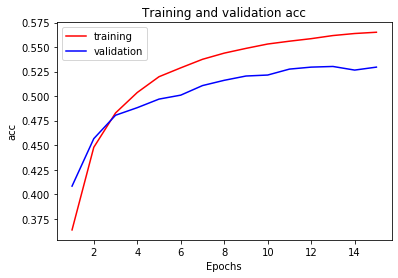

In [27]:
# Generate plots to assess the performance of the NN
ev.plot_learning_curve(history_dict = FNN_history_dict, metric = 'acc', set = 'train_valid')

In [28]:
# Test prediction for a single given cue sequence. Model expect input as array of shape (1, N_cues) 
cue1_seq = 'I_will_meet_you_tomorrow'
outcome1_prob_pred = ev.predict_proba_oneevent_FNN(model = FNN_model, 
                                                   cue_seq = cue1_seq, 
                                                   num_cues = N_cues,  
                                                   cue_index = cue_to_index)
print(outcome1_prob_pred) # vector of predicted probabilities
print({index_to_outcome[j+1]:outcome1_prob_pred[j] for j in range(len(outcome1_prob_pred))})

[0.51402503 0.17794494 0.30803007]
{'FutureSimple': 0.51402503, 'PastSimple': 0.17794494, 'PresentSimple': 0.30803007}


In [29]:
# Evaluate the model on the test set
prob_pred = ev.predict_proba_eventfile_FNN(model = FNN_model, 
                                           data_test = tenses_test, 
                                           num_cues = N_cues, 
                                           num_outcomes = N_outcomes, 
                                           cue_index = cue_to_index, 
                                           outcome_index = outcome_to_index)

In [30]:
# True responses to compare the predictions to
y_test = tenses_test.replace({'outcomes': outcome_to_index})['outcomes']
y_pred = np.argmax(prob_pred, axis=1)+1

# Overall test accuracy
test_accuracy = accuracy_score(y_test, y_pred)
test_accuracy

0.5303333333333333

In [31]:
# Test accuracy per class
cmat = confusion_matrix(y_test, y_pred) # Confusion matrix
print(cmat.diagonal()/cmat.sum(axis=1)) 

[0.56987116 0.59021407 0.43267327]


## IV. Long short-term memory model <a ID="IV"></a> 

### Build a simple LSTM model

Build a simple LSTM that has 64 hidden units 

In [32]:
### Build a simple LSTM that has 64 hidden units 
p = {'epochs': 10, # number of iterations on the full set 
    'batch_size': 16, 
    'hidden_neuron': 64, # number of neurons in the input layer 
    'lr': 0.0001, # learning rate       
    'dropout': 0.2, 
    'optimizer': RMSprop, 
    'losses': categorical_crossentropy, 
    'last_activation': 'softmax'}

# Model fitting
LSTM_out, LSTM_model = md.train_LSTM(data_train = tenses_train, 
                                     data_valid = tenses_valid, 
                                     cue_index = cue_to_index, 
                                     outcome_index = outcome_to_index, 
                                     max_len = max_len,
                                     use_multiprocessing = True, 
                                     num_threads = no_threads, 
                                     verbose = 2,
                                     metrics = ['accuracy'],
                                     params = p)

Epoch 1/10
 - 58s - loss: 1.0622 - acc: 0.4174 - val_loss: 1.0068 - val_acc: 0.4686
Epoch 2/10
 - 55s - loss: 0.9978 - acc: 0.4849 - val_loss: 0.9886 - val_acc: 0.4893
Epoch 3/10
 - 55s - loss: 0.9780 - acc: 0.5005 - val_loss: 0.9807 - val_acc: 0.4963
Epoch 4/10
 - 58s - loss: 0.9671 - acc: 0.5123 - val_loss: 0.9790 - val_acc: 0.4993
Epoch 5/10
 - 54s - loss: 0.9594 - acc: 0.5208 - val_loss: 0.9767 - val_acc: 0.5060
Epoch 6/10
 - 55s - loss: 0.9536 - acc: 0.5305 - val_loss: 0.9760 - val_acc: 0.4983
Epoch 7/10
 - 56s - loss: 0.9490 - acc: 0.5345 - val_loss: 0.9768 - val_acc: 0.5097
Epoch 8/10
 - 74s - loss: 0.9465 - acc: 0.5390 - val_loss: 0.9740 - val_acc: 0.5110
Epoch 9/10
 - 73s - loss: 0.9425 - acc: 0.5395 - val_loss: 0.9740 - val_acc: 0.5114
Epoch 10/10
 - 73s - loss: 0.9383 - acc: 0.5472 - val_loss: 0.9794 - val_acc: 0.5134


In [33]:
LSTM_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                528640    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 528,835
Trainable params: 528,835
Non-trainable params: 0
_________________________________________________________________


### Tune the parameters to find a good model

In [34]:
### Parameter tuning using grid search 
p = {'epochs': [5, 10, 20, 30], # number of iterations on the full set (x5)
     'batch_size': [16, 32, 64, 128, 256], # (x5)
     'hidden_neuron':[16, 32, 64, 128], # number of neurons in the input layer (x4)
     'lr': [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01], # learning rate (x7)       
     'dropout': [0, 0.1, 0.2, 0.3, 0.4], # (x5)
     'optimizer': [Adam, Nadam, RMSprop, SGD], # (x4)
     'losses': [categorical_crossentropy], # (x1)
     'last_activation': ['softmax'] # (x1)
     }
# => Total number of combinations: 4*5*4*7*5*4*1*1 = 11200

### Grid search 
TUNING_PATH = TOP + 'illustrative_examples/tenses/Results/grid_search_LSTM_tenses.csv'
md.grid_search_LSTM(data_train = tenses_train, 
                    data_valid = tenses_valid, 
                    cue_index = cue_to_index, 
                    outcome_index = outcome_to_index,
                    max_len = max_len,
                    params = p,
                    prop_grid = 4e-4, 
                    tuning_output_file = TUNING_PATH, 
                    use_multiprocessing = True, 
                    num_threads = no_threads)

Iteration 1 out of 4: {'epochs': 20, 'batch_size': 128, 'hidden_neuron': 16, 'lr': 0.002, 'dropout': 0.1, 'optimizer': <class 'keras.optimizers.SGD'>, 'losses': <function categorical_crossentropy at 0x7f302a23a488>, 'last_activation': 'softmax'}

Iteration 2 out of 4: {'epochs': 5, 'batch_size': 128, 'hidden_neuron': 16, 'lr': 0.01, 'dropout': 0.1, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function categorical_crossentropy at 0x7f302a23a488>, 'last_activation': 'softmax'}

Iteration 3 out of 4: {'epochs': 20, 'batch_size': 16, 'hidden_neuron': 128, 'lr': 0.0002, 'dropout': 0, 'optimizer': <class 'keras.optimizers.Nadam'>, 'losses': <function categorical_crossentropy at 0x7f302a23a488>, 'last_activation': 'softmax'}

Iteration 4 out of 4: {'epochs': 20, 'batch_size': 16, 'hidden_neuron': 128, 'lr': 0.001, 'dropout': 0.4, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function categorical_crossentropy at 0x7f302a23a488>, 'last_activation': 'softmax'}



### Assessing the grid search using talos

In [35]:
# Import the results file to analyse the results with talos
r = ta.Reporting(TUNING_PATH)

# get the highest result for any metric
print(f"- Highest validation accuracy: {r.high('val_acc')}")
print(f"- Highest validation f1-score: {r.high('f1score')}")

- Highest validation accuracy: 0.5320855614973262
- Highest validation f1-score: 0.8539664087295532


In [36]:
# get the index of the combination with the best result
r.rounds2high(metric = 'val_acc')

34

In [37]:
# get the best paramaters
r.data.iloc[34,]

epochs                                                                10
batch_size                                                            16
hidden_neuron                                                        128
lr                                                                0.0002
dropout                                                                0
optimizer                               <class 'keras.optimizers.Nadam'>
losses             <function categorical_crossentropy at 0x7f302a23a488>
last_activation                                                  softmax
loss                                                            0.831479
acc                                                             0.617542
precision                                                       0.687606
recall                                                          0.488667
f1score                                                         0.567265
val_loss                                           

### Retraining with the best parameters

In [ ]:
### Hyperparameters to use
p = {'epochs': 10, # number of iterations on the full set 
    'batch_size': 16, 
    'hidden_neuron': 128, # number of neurons in the input layer 
    'lr': 0.0002, # learning rate       
    'dropout': 0, 
    'optimizer': Nadam, 
    'losses': categorical_crossentropy, 
    'last_activation': 'softmax'}

# Model fitting
LSTM_hist, LSTM_model = md.train_LSTM(data_train = tenses_train, 
                                     data_valid = tenses_valid, 
                                     cue_index = cue_to_index, 
                                     outcome_index = outcome_to_index, 
                                     max_len = max_len,
                                     use_multiprocessing = True, 
                                     num_threads = no_threads, 
                                     verbose = 2,
                                     metrics = ['accuracy'],
                                     params = p)

In [40]:
# Save the model and training history
MODEL_PATH = TOP + 'illustrative_examples/tenses/Results/LSTM_tenses.h5'
HISTORY_PATH = TOP + 'illustrative_examples/tenses/Results/LSTM_history_dict_tenses'
md.export_model(model = LSTM_model, path = MODEL_PATH)  # creates a HDF5 file 
md.export_history(history_dict = LSTM_hist, path = HISTORY_PATH)
del LSTM_model, LSTM_hist  # deletes the existing model and history dictionary

In [ ]:
# Load the model and training history
MODEL_PATH = TOP + 'illustrative_examples/tenses/Results/LSTM_tenses.h5'
HISTORY_PATH = TOP + 'illustrative_examples/tenses/Results/LSTM_history_dict_tenses'
LSTM_model = md.import_model(MODEL_PATH)
LSTM_history_dict = md.import_history(path = HISTORY_PATH)

### Evaluate the final model

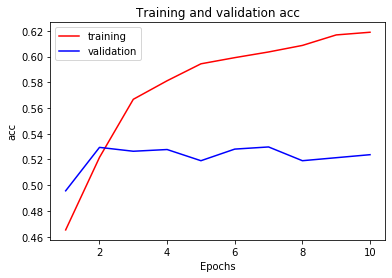

In [42]:
# Generate plots to assess the performance of the simple LSTM
ev.plot_learning_curve(history_dict = LSTM_history_dict, metric = 'acc', set = 'train_valid')

In [43]:
# Test prediction for a single given cue sequence. Model expect inout as array of shape (1, N_cues) 
cue1_seq = 'I_will_meet_you_tomorrow'
outcome1_prob_pred = ev.predict_proba_oneevent_LSTM(model = LSTM_model, 
                                                   cue_seq = cue1_seq, 
                                                   num_cues = N_cues,  
                                                   cue_index = cue_to_index,
                                                   max_len = max_len)
print(outcome1_prob_pred) # vector of predicted probabilities
print({index_to_outcome[j+1]:outcome1_prob_pred[j] for j in range(len(outcome1_prob_pred))})

[0.87768716 0.01196589 0.11034696]
{'FutureSimple': 0.87768716, 'PastSimple': 0.011965892, 'PresentSimple': 0.11034696}


In [44]:
# Evaluate the model on the test set
prob_pred = ev.predict_proba_eventfile_LSTM(model = LSTM_model, 
                                           data_test = tenses_test, 
                                           num_cues = N_cues, 
                                           num_outcomes = N_outcomes, 
                                           cue_index = cue_to_index, 
                                           outcome_index = outcome_to_index, 
                                           max_len = max_len,  
                                           use_multiprocessing = True, 
                                           num_threads = no_threads)

In [45]:
# True responses to compare the predictions to
y_test = tenses_test.replace({'outcomes': outcome_to_index})['outcomes']
y_pred = np.argmax(prob_pred, axis=1)+1

# Overall test accuracy
test_accuracy = accuracy_score(y_test, y_pred)
test_accuracy

0.5236666666666666

In [46]:
# Test accuracy per class
cmat = confusion_matrix(y_test, y_pred) # Confusion matrix
print(cmat.diagonal()/cmat.sum(axis=1)) 

[0.53716551 0.60754332 0.42871287]


## V. Naive discriminative learning model <a ID="V"></a> 

### Build a simple NDL model

In [47]:
### Build a simple NDL
p = {'epochs': 10, # number of iterations on the full set 
    'lr': 0.001}

# Model fitting
NDL_history_dict, NDL_model = md.train_NDL(data_train = tenses_train, 
                                           data_valid = tenses_valid,  
                                           cue_index = cue_to_index, 
                                           outcome_index = outcome_to_index, 
                                           temp_dir = TEMP_DIR,
                                           num_threads = no_threads, 
                                           verbose = 1,
                                           params = p)

Epoch 1/10
 - 59s - acc: 0.5170 - val_acc: 0.5047
Epoch 2/10
 - 58s - acc: 0.5375 - val_acc: 0.5131
Epoch 3/10
 - 58s - acc: 0.5480 - val_acc: 0.5255
Epoch 4/10
 - 57s - acc: 0.5571 - val_acc: 0.5315
Epoch 5/10
 - 56s - acc: 0.5613 - val_acc: 0.5332
Epoch 6/10
 - 57s - acc: 0.5667 - val_acc: 0.5322
Epoch 7/10
 - 57s - acc: 0.5715 - val_acc: 0.5301
Epoch 8/10
 - 59s - acc: 0.5751 - val_acc: 0.5311
Epoch 9/10
 - 60s - acc: 0.5771 - val_acc: 0.5311
Epoch 10/10
 - 59s - acc: 0.5794 - val_acc: 0.5338


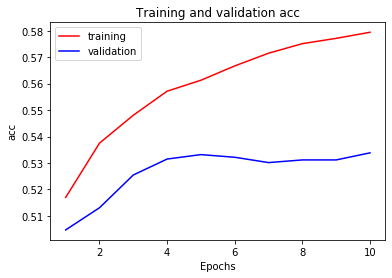

In [48]:
# Generate learning curve
ev.plot_learning_curve(history_dict = NDL_history_dict, metric = 'acc', set = 'train_valid')

### Tune the parameters to find a good model

In [51]:
### Parameter tuning using grid search 
p = {'lr': [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05], # learning rate (x8)
     'epochs': [4, 6, 8, 10], # number of iterations on the full set (x6)
     }
# => Total number of combinations: 8*4 = 32

### Grid search 
TUNING_PATH = TOP + 'illustrative_examples/tenses/Results/grid_search_NDL_tenses.csv'
md.grid_search_NDL(data_train = tenses_train, 
                   data_valid = tenses_valid, 
                   cue_index = cue_to_index, 
                   outcome_index = outcome_to_index, 
                   temp_dir = TEMP_DIR,
                   params = p, 
                   prop_grid = 0.3, 
                   tuning_output_file = TUNING_PATH, 
                   num_threads = no_threads)

Iteration 1 out of 10: {'lr': 0.0001, 'epochs': 10}

Iteration 2 out of 10: {'lr': 0.05, 'epochs': 8}

Iteration 3 out of 10: {'lr': 0.0001, 'epochs': 8}

This parameter combination has already been processed: {'lr': 0.0001, 'epochs': 8}

Iteration 4 out of 10: {'lr': 0.05, 'epochs': 4}

This parameter combination has already been processed: {'lr': 0.05, 'epochs': 4}

Iteration 5 out of 10: {'lr': 0.005, 'epochs': 10}

Iteration 6 out of 10: {'lr': 0.005, 'epochs': 6}

This parameter combination has already been processed: {'lr': 0.005, 'epochs': 6}

Iteration 7 out of 10: {'lr': 0.0001, 'epochs': 6}

This parameter combination has already been processed: {'lr': 0.0001, 'epochs': 6}

Iteration 8 out of 10: {'lr': 0.0001, 'epochs': 4}

This parameter combination has already been processed: {'lr': 0.0001, 'epochs': 4}

Iteration 9 out of 10: {'lr': 0.001, 'epochs': 4}

Iteration 10 out of 10: {'lr': 0.01, 'epochs': 6}



### Assessing the grid search using talos

In [52]:
# Import the results file to analyse the results with talos
r = ta.Reporting(TUNING_PATH)

# get the highest result for any metric
print(f"- Highest validation accuracy: {r.high('val_acc')}")
print(f"- Highest validation f1-score: {r.high('f1score')}")

- Highest validation accuracy: 0.5314802411252512
- Highest validation f1-score: 0.6002221268311221


In [53]:
# get the index of the combination with the best result
r.rounds2high(metric = 'val_acc')

31

In [54]:
# get the best paramaters
r.data.iloc[31,]

lr               0.001000
epochs           4.000000
acc              0.557128
precision        0.555637
recall           0.556927
f1score          0.554380
val_acc          0.531480
val_precision    0.529459
val_recall       0.532323
val_f1score      0.528716
Name: 31, dtype: float64

### Retraining with the best parameters

In [55]:
### Hyperparameters to use
p = {'epochs': 4, # number of iterations on the full set 
    'lr': 0.001}

# Model fitting
NDL_hist, NDL_model = md.train_NDL(data_train = tenses_train, 
                                   data_valid = tenses_valid,  
                                   cue_index = cue_to_index, 
                                   outcome_index = outcome_to_index, 
                                   temp_dir = TEMP_DIR,
                                   num_threads = no_threads, 
                                   verbose = 1,
                                   params = p)

Epoch 1/4
 - 61s - acc: 0.5170 - val_acc: 0.5047
Epoch 2/4
 - 61s - acc: 0.5375 - val_acc: 0.5131
Epoch 3/4
 - 60s - acc: 0.5480 - val_acc: 0.5255
Epoch 4/4
 - 60s - acc: 0.5571 - val_acc: 0.5315


In [58]:
# Save the weights and training history
MODEL_PATH = TOP + 'illustrative_examples/tenses/Results/NDL_tenses.h5'
HISTORY_PATH = TOP + 'illustrative_examples/tenses/Results/NDL_history_dict_tenses'
md.export_model(model = NDL_model, path = MODEL_PATH)  # create a HDF5 file 
md.export_history(history_dict = NDL_hist, path = HISTORY_PATH)
del NDL_model, NDL_history_dict  # delete the existing model and history dictionary

In [59]:
# Load the model and training history
MODEL_PATH = TOP + 'illustrative_examples/tenses/Results/NDL_tenses.h5'
HISTORY_PATH = TOP + 'illustrative_examples/tenses/Results/NDL_history_dict_tenses'
NDL_model = md.import_model(MODEL_PATH)
NDL_history_dict = md.import_history(path = HISTORY_PATH)

### Evaluate the final model

In [60]:
# Test prediction for a single given cue sequence. Model expect input as array of shape (1, N_cues) 
cue1_seq = 'I_will_meet_you_tomorrow'
outcome1_prob_pred = ev.predict_proba_oneevent_NDL(model = NDL_model, 
                                                   cue_seq = cue1_seq)
print(outcome1_prob_pred) # vector of predicted probabilities
print({index_to_outcome[j+1]:outcome1_prob_pred[j] for j in range(len(outcome1_prob_pred))})

[0.41697187 0.25885755 0.32417057]
{'FutureSimple': 0.416971873230594, 'PastSimple': 0.2588575517857205, 'PresentSimple': 0.32417057498368557}


The probability of future seems low, not because the model is unconfident, but because the softmax transformation used is 'soft' in terms of converting activations to probabilities. Decreasing the temperature parameter can emphasise more the predictions bewteen the three tense: 

In [61]:
# Test prediction for a single given cue sequence. Model expect input as array of shape (1, N_cues) 
cue1_seq = 'I_will_meet_you_tomorrow'
outcome1_prob_pred = ev.predict_proba_oneevent_NDL(model = NDL_model, 
                                                   cue_seq = cue1_seq,
                                                   T = 0.1)
print(outcome1_prob_pred) # vector of predicted probabilities
print({index_to_outcome[j+1]:outcome1_prob_pred[j] for j in range(len(outcome1_prob_pred))})

[0.91813516 0.00780634 0.0740585 ]
{'FutureSimple': 0.9181351587834573, 'PastSimple': 0.007806338970140522, 'PresentSimple': 0.07405850224640231}


In [62]:
# Evaluate the model on the test set
prob_pred = ev.predict_proba_eventfile_NDL(model = NDL_model, 
                                           data_test = tenses_test, 
                                           temp_dir = TEMP_DIR,
                                           num_threads = no_threads)

In [63]:
# True responses to compare the predictions to
y_test = tenses_test.replace({'outcomes': outcome_to_index})['outcomes']
y_pred = np.argmax(prob_pred, axis=1)+1

# Overall test accuracy
test_accuracy = accuracy_score(y_test, y_pred)
test_accuracy

0.5296666666666666

In [64]:
# Test accuracy per class
cmat = confusion_matrix(y_test, y_pred) # Confusion matrix
print(cmat.diagonal()/cmat.sum(axis=1)) 

[0.58572844 0.55351682 0.45049505]
